# Template for device simulation with aihwkit

The following snippet is to make sure aihwkit is installed and functioning correctly:

In [1]:
from torch import Tensor
from aihwkit.nn import AnalogLinear

model = AnalogLinear(2, 2)
model(Tensor([[0.1, 0.2], [0.3, 0.4]]))

tensor([[0.1201, 0.5192],
        [0.1296, 0.5474]], grad_fn=<AddBackward0>)

Import necessary libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.style.use('ggplot')

## Download MNIST data

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


PATH_DATASET = os.path.join('/scratch/msc24h18/msc_project/data', 'DATASET')
os.makedirs(PATH_DATASET, exist_ok=True)

def get_data_loaders(batch_size=5):
    """Get the data loaders for train from torchvision datasets."""

    train_set = MNIST(PATH_DATASET, download=True, train=True, transform=ToTensor())
    test_set = MNIST(PATH_DATASET, download=True, train=False, transform=ToTensor())
    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    test_data = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_data, test_data

## Read device data

In [4]:
working_dir = '/scratch/msc24h18/msc_project'
rel_path = 'data/LBE247_analyzed/LBE247_ID301XR1000Oct/pulsedAmplitudeSweep_DCIV_20240919143913/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(0)]20240919143914/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(0)]20240919143914_Summary.dat'

data = pd.read_csv(os.path.join(working_dir, rel_path), skiprows=6)

data.head()

,Pulse Number,index,Pulse Amplitude (V),R_low (ohm),R_high (ohm)
0,1,2,0.2,4.901961e+09,5.564830e+09
1,2,3,0.3,4.943154e+09,5.608525e+09
2,3,4,0.4,5.117707e+09,5.854801e+09
3,4,5,0.5,5.656109e+09,6.476684e+09
4,5,6,0.6,6.134969e+09,7.002801e+09


Extract conductance vs pulse number data and plot:

Number of LTP pulses: 24
Number of LTD pulses: 24


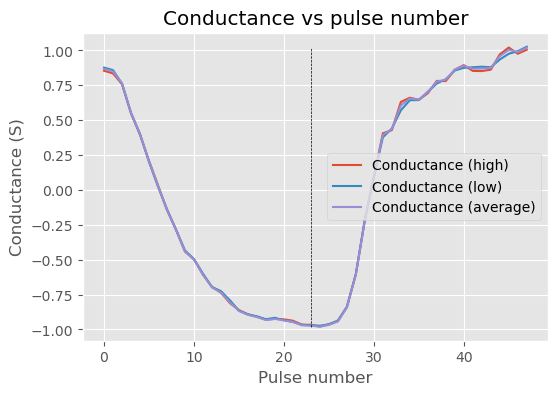

In [ ]:
conductance_l = np.array(1 / data['R_high (ohm)'])
conductance_h = np.array(1 / data['R_low (ohm)'])
conductance = (conductance_l + conductance_h) / 2

def normalize(c):
    return 2 * (c - c.mean()) / (c.max() - c.min())

conductance_l = normalize(conductance_l)
conductance_h = normalize(conductance_h)
conductance = normalize(conductance)

pulses = np.array([-1 if v > 0 else 1 for v in data['Pulse Amplitude (V)']]) # ltp pulses are expected to be positive for fitting to work
conductance_ltp = conductance[np.where(pulses == 1)[0]]
conductance_ltd = conductance[np.where(pulses == -1)[0]]
pulse_change_idx = np.where(np.diff(pulses) != 0)[0]

print(f"Number of LTP pulses: {len(conductance_ltp)}")
print(f"Number of LTD pulses: {len(conductance_ltd)}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance_h, label='Conductance (high)')
ax.plot(conductance_l, label='Conductance (low)')
ax.plot(conductance, label='Conductance (average)')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

Define device model and use fitting utility to fit data:

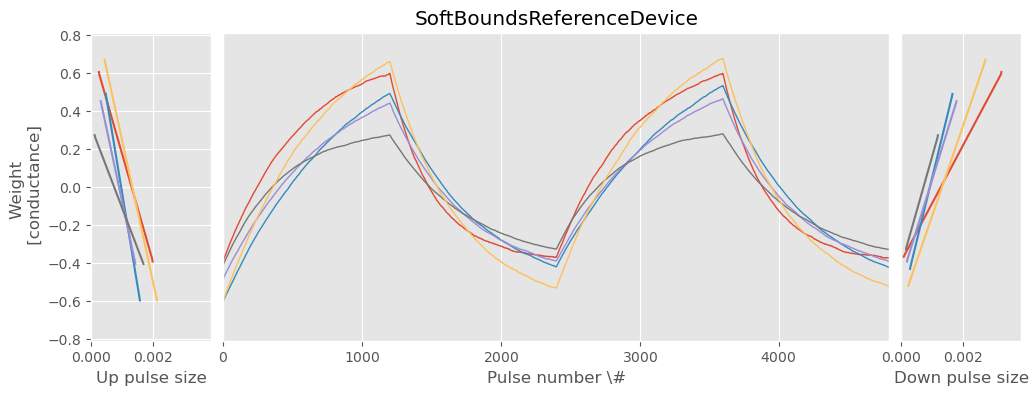

In [6]:
from aihwkit.utils.visualization import plot_device_compact
from aihwkit.simulator.configs import SoftBoundsReferenceDevice

device_config = SoftBoundsReferenceDevice(
    # shown values are the defaults
    w_min_dtod=0.3,     # device-to-device variation for the minimum weight
    w_max_dtod=0.3,     # device-to-device variation for the maximum weight
    dw_min_dtod=0.3,    # device-to-device variation for the minimum weight change (delta weight due to a single pulse)
    up_down_dtod=0.01,   # device-to-device variation of asymmetry between up and down step sizes
    dw_min_std=0.3      # pulse-to-pulse variation for the minimum weight change (delta weight due to a single pulse)
)
plot_device_compact(device_config, n_traces=5); # semicolon avoids duplicate plots

We use the provided fitting utility to fit the parameters `dw_min` (pulse width at weight zero), `w_max` and `w_min` (min and maximim bound in normalized units), and `up_down` which is the amount of asymmetry between up and down behaviour. The fitting tool expects the initial setting and ranges of these parameters

SoftBoundsReferenceDevice(
    dw_min=0.13718250397816395,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.1674426933071862,
    up_down_dtod=0.0,
    w_max=1.2250248754883963,
    w_max_dtod=0.0,
    w_min=-1.5900590423300296,
    w_min_dtod=0.0
)


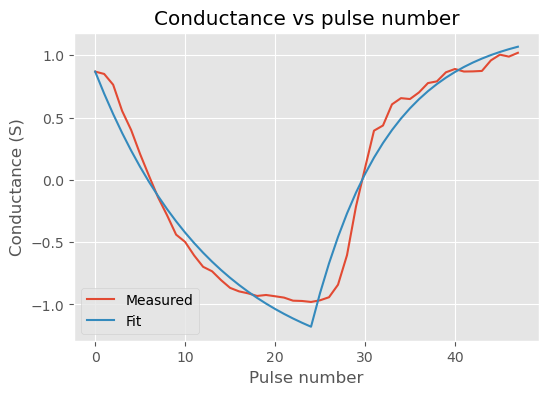

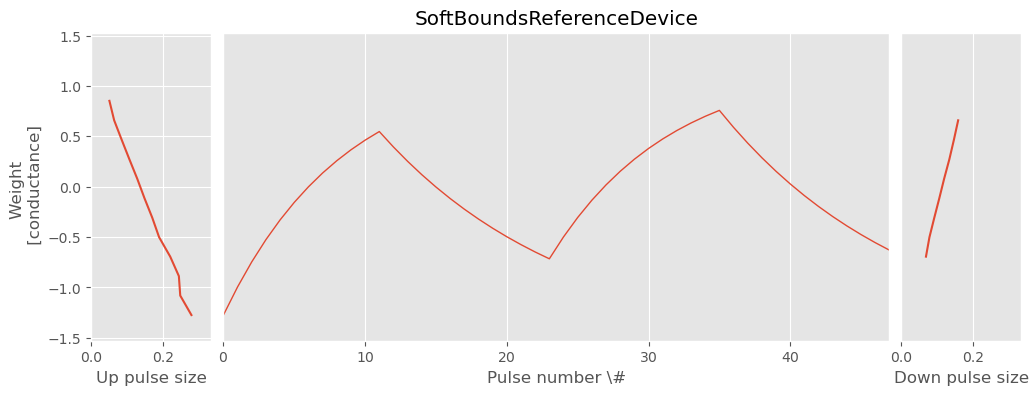

In [7]:
from aihwkit.utils.fitting import fit_measurements

params = {'dw_min': (0.1, 0.001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

result, device_config_fit, best_model_fit = fit_measurements(
    params,
    pulses,
    conductance,
    device_config)

print(device_config_fit)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance, label='Measured')
ax.plot(best_model_fit, label='Fit')
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

plot_device_compact(device_config_fit, n_traces=1, n_steps=12);

If we have more than one measurement, the code above will estimate device-to-device variations. Otherwise, we have to guess. Additionally, we can estimate the noise using the code below:

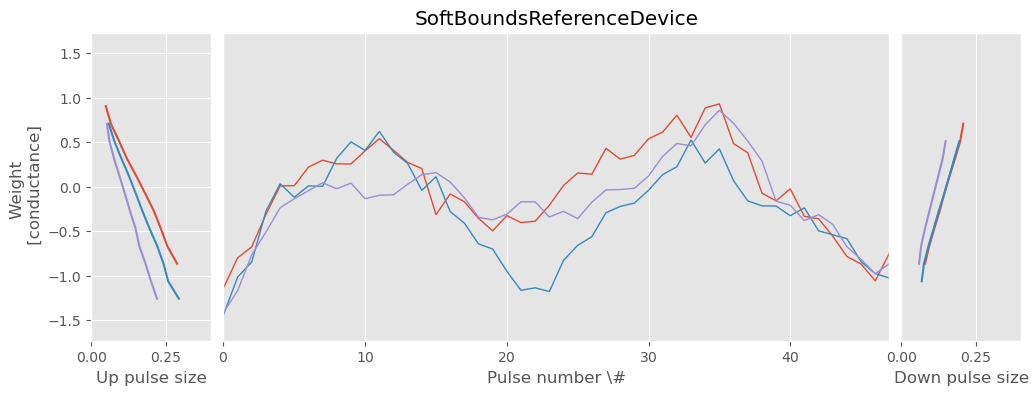

In [ ]:
# add some device-to-device varition and noise
std = (conductance - best_model_fit).std() / device_config_fit.dw_min
#                                                   default value
device_config_fit.dw_min_dtod = 0.3                 # 0.3
device_config_fit.dw_min_std = 1.0                  # 5.0
device_config_fit.w_min_dtod = 0.1                  # 0.1
device_config_fit.w_max_dtod = 0.1                  # 0.1
device_config_fit.up_down_dtod = 0.05               # 0.05
device_config_fit.write_noise_std = 0               # np.sqrt(std ** 2 - device_config_fit.dw_min_std ** 2)/2
device_config_fit.subtract_symmetry_point = True    # True
device_config_fit.reference_std = 0.05              # 0.05  # assumed programming error of the reference device
device_config_fit.enforce_consistency=True          # True  # do not allow dead devices
device_config_fit.dw_min_dtod_log_normal=True       # True # more realistic to use log-normal
device_config_fit.mult_noise=False                  # False # additive noise
device_config_fit.construction_seed = 123           # 123

plot_device_compact(device_config_fit, n_traces=3, n_steps=12);

## In-memory training

Define a function that returns an RPU config.
The UpdateParameters can be used to customize how the analog tile delivers the updated pulses to the device to change the conductance states. See the [available pulse types](https://aihwkit.readthedocs.io/en/latest/api/aihwkit.simulator.parameters.enums.html#aihwkit.simulator.parameters.enums.PulseType). The default is 'StochasticCompressed'. Use 'None' for floating-point update (no stochastic pulses).

Other parameters such as defining the MVM non-linearities of the forward and backward passes, the mapping to tiles, and the digital periphery can be customized by setting the corresponding fields in the `rpu_config`. We leave them at default values here.

In [9]:
from aihwkit.simulator.parameters.enums import PulseType
from aihwkit.simulator.configs import UpdateParameters
from aihwkit.simulator.configs import build_config

def get_rpu_config(device=device_config_fit, algorithm='ttv2', pulse_type='StochasticCompressed'):
    rpu_config = build_config(algorithm,
                              device=device,
                              up_parameters=UpdateParameters(pulse_type=PulseType(pulse_type)),
                              construction_seed=123)
    if algorithm == 'ttv2' or algorithm == 'c-ttv2' or algorithm == 'agad':
        # update onto A matrix needs to be increased somewhat
        rpu_config.mapping.learn_out_scaling = True
        rpu_config.mapping.weight_scaling_columnwise = True
        rpu_config.mapping.weight_scaling_omega = 0.6
        rpu_config.device.fast_lr = 0.01
        rpu_config.device.auto_granularity=15000

    return rpu_config

Define the network structure in pytorch and the pytorch lightning module:

In [10]:
from torch import nn, argmax
from torch.nn.functional import nll_loss
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

from aihwkit.optim import AnalogSGD
from aihwkit.nn.conversion import convert_to_analog_mapped

import logging

def create_network():
    """Create the neural network using digital layers.
    Returns:
        nn.Module: created analog model
    """

    input_size = 784
    hidden_sizes = [256, 128]
    output_size = 10

    model = nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0], True),
        nn.Sigmoid(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1], True),
        nn.Sigmoid(),
        nn.Linear(hidden_sizes[1], output_size, True),
        nn.LogSoftmax(dim=1)
    )
    return model

# lightning module
class LitAnalogModel(pl.LightningModule):
    def __init__(self, model, rpu_config, lr=0.05):
        super().__init__()

        # We simply convert the given model to analog on-the-fly
        self.analog_model = convert_to_analog_mapped(model, rpu_config)
        self.lr = lr

    def forward(self, x):
        x_reshaped = x.reshape(x.shape[0], -1)
        return self.analog_model(x_reshaped)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nll_loss(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        # we need to use the analog-aware optimizers
        optimizer = AnalogSGD(
            self.analog_model.parameters(),
            lr=self.lr,
        )
        return optimizer
    
# reduce the output verbosity
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.CRITICAL)


def build_trainer(rpu_config, lr=0.1, max_epochs=3, log="1"):
    """Build the lightning model and resurn the trainer"""

    trainer = pl.Trainer(
        enable_model_summary=False,
        logger=pl.loggers.CSVLogger(save_dir=os.path.join("logs/template", log)),
        callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=10)],
        max_epochs=max_epochs,
    )

    model = LitAnalogModel(lr=lr, rpu_config=rpu_config, model=create_network())
    return trainer, model

def fit_model(trainer, model):
    """Train the model using lightning trainer."""

    trainer.fit(model, *get_data_loaders(batch_size=5))
    trainer.test(model, get_data_loaders(batch_size=100)[1])

def plot_loss(trainer, tstr=''):
    """Plot the train loss for each batch."""
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    metrics.plot("step", "train_loss")
    plt.ylabel("Loss")
    plt.title(tstr)
    return plt.gcf()

### Train

Testing DataLoader 0: 100%|██████████| 100/100 [00:00<00:00, 454.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7595000267028809
        test_loss           0.7406708002090454
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


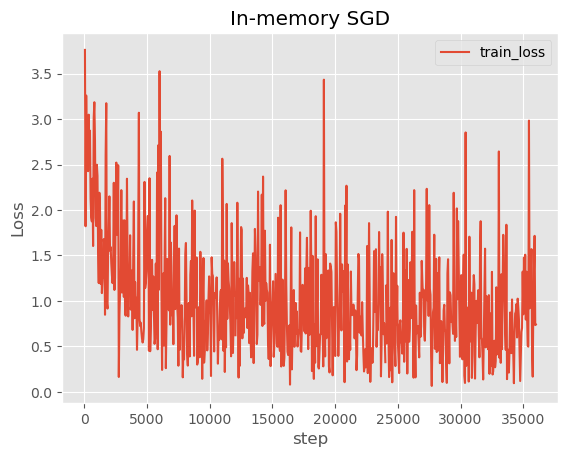

In [13]:
# sgd
trainer, model = build_trainer(get_rpu_config(device=device_config_fit, algorithm="sgd"), log="sgd", max_epochs=3)
fit_model(trainer, model)
plot_loss(trainer, "In-memory SGD");

Testing DataLoader 0: 100%|██████████| 100/100 [00:00<00:00, 443.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9059000015258789
        test_loss           0.32496801018714905
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


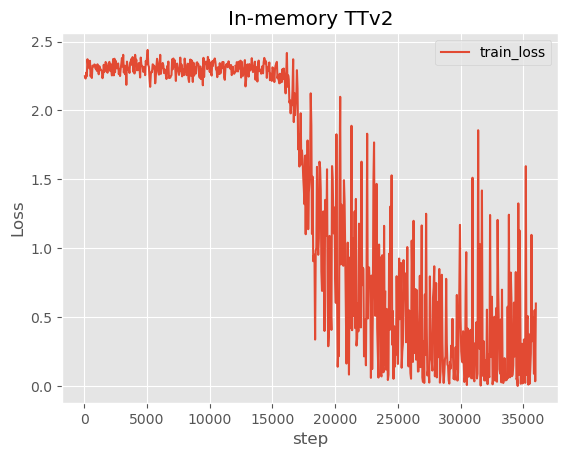

In [12]:
# ttv2
trainer, model = build_trainer(get_rpu_config(device=device_config_fit, algorithm="ttv2"), log="ttv2", max_epochs=3)
fit_model(trainer, model)
plot_loss(trainer, "In-memory TTv2");

Testing DataLoader 0: 100%|██████████| 100/100 [00:00<00:00, 541.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9596999883651733
        test_loss            0.128797248005867
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


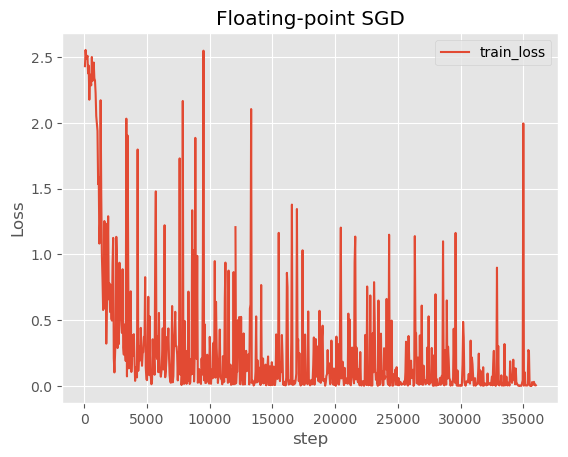

In [15]:
# sgd with floating-point update
trainer, model = build_trainer(get_rpu_config(device=device_config_fit, algorithm="sgd", pulse_type="None"), log="sgd-fp", max_epochs=3)
fit_model(trainer, model)
plot_loss(trainer, "Floating-point SGD");

Testing DataLoader 0: 100%|██████████| 100/100 [00:00<00:00, 366.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8949000239372253
        test_loss           0.31810930371284485
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


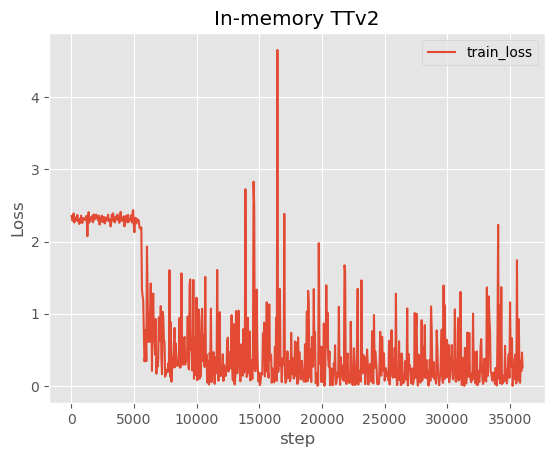

In [14]:
# ttv2 with floating-point update
trainer, model = build_trainer(get_rpu_config(device=device_config_fit, algorithm="ttv2", pulse_type="None"), log="ttv2-fp", max_epochs=3)
fit_model(trainer, model)
plot_loss(trainer, "Floating-point TTv2");